In [1]:
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_vit = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


cuda


In [3]:


trainset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_vit)

testset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_vit)

trainset_cnn = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_cnn)

testset_cnn = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_cnn)

trainloader_vit = torch.utils.data.DataLoader(
    trainset_vit, batch_size=128, shuffle=True)

testloader_vit = torch.utils.data.DataLoader(
    testset_vit, batch_size=128, shuffle=False)

trainloader_cnn = torch.utils.data.DataLoader(
    trainset_cnn, batch_size=128, shuffle=True)

testloader_cnn = torch.utils.data.DataLoader(
    testset_cnn, batch_size=128, shuffle=False)

classes = (
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse',
    'ship', 'truck'
)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [5]:
from torchvision.models import vit_b_16

def get_vit_model(num_classes=10, freeze_backbone=True):

    model_vit = vit_b_16(weights="IMAGENET1K_V1")
    model_vit.heads.head = nn.Linear(
        model_vit.heads.head.in_features, num_classes)

    if freeze_backbone:
        for param in model_vit.parameters():
            param.requires_grad = False
        for param in model_vit.heads.head.parameters():
            param.requires_grad = True
    return model_vit

In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        acc = 100 * correct / total

        pbar.set_postfix(
            loss=loss.item(),
            acc=f"{acc:.2f}%"
        )

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [7]:
def train_model(model, train_loader, test_loader, epochs, lr, name, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if hasattr(model, "heads"):
        optimizer = torch.optim.Adam(model.heads.head.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": [],
               "epoch_time": []
    }

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device, epoch
        )
        val_loss, val_acc = evaluate(
            model, test_loader, criterion ,device
        )
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start_time
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(epoch_time)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
            f"⏱ Time: {epoch_time:.1f}s"
        )
    total_time = time.time() - total_start_time
    print(f"✅ Total training time for {name}: {total_time/60:.2f} minutes")

    return history

In [8]:
def evaluate(model, loader, criterion, device, epoch=None, epochs=None):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    desc = "Validation" if epoch is None else f"Epoch {epoch+1}/{epochs} [Val]"
    val_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_bar.set_postfix(
                loss=loss.item(),
                accuracy= 100 * correct / total
            )
    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc

In [9]:
def plot_history(histories):
    # Loss
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
        plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curves")
    plt.show()

    # Accuracy
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["train_acc"], label=f"{name} Train Acc")
        plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curves")
    plt.show()


In [10]:
def plot_times_and_efficiency(histories):
    # --- Plot epoch times ---
    plt.figure(figsize=(12,5))
    for name, history in histories.items():
        plt.plot(history["epoch_time"], marker="o", label=name)
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Compute efficiency ---
    names = []
    efficiencies = []

    for name, history in histories.items():
        total_time = sum(history["epoch_time"])
        final_acc = history["val_acc"][-1]
        sec_per_acc = total_time / final_acc

        names.append(name)
        efficiencies.append(sec_per_acc)

    # --- Bar plot efficiency ---
    plt.figure(figsize=(10,5))
    plt.bar(names, efficiencies)
    plt.ylabel("Seconds per 1% Accuracy")
    plt.title("Efficiency: Time Cost per Accuracy Unit")
    plt.xticks(rotation=30)
    plt.grid(True, axis="y")
    plt.show()

    # --- Print numeric table ---
    print("\n⏱ Efficiency Table:")
    for name, eff in zip(names, efficiencies):
        print(f"{name:15s} : {eff:.2f} seconds per 1% accuracy")


In [11]:
import seaborn
from sklearn.metrics import confusion_matrix


def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10,8))
    seaborn.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


In [12]:
def train_with_time_budget(model, train_loader, test_loader,
                           max_seconds, lr, device, name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if hasattr(model, "heads"):
        optimizer = torch.optim.Adam(model.heads.head.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "time": [],
        "train_acc": [],
        "val_acc": []
    }

    start_time = time.time()
    epoch = 0

    while True:
        epoch_start = time.time()

        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        elapsed = time.time() - start_time

        history["time"].append(elapsed)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"[{name}] Epoch {epoch+1} | "
            f"Time: {elapsed:.1f}s | "
            f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
        )

        epoch += 1

        if elapsed >= max_seconds:
            print(f"⏱ Time budget reached for {name}")
            break

    return history

def plot_accuracy_vs_time(histories):
    plt.figure(figsize=(10,6))

    for name, history in histories.items():
        plt.plot(
            history["time"],
            history["val_acc"],
            marker="o",
            label=name
        )

    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Accuracy vs Training Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def show_predictions(model, loader, classes, device, num_images=8):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(16,8))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    plt.show()
                    return

                img = images[i].cpu()
                img = img * 0.5 + 0.5  # unnormalize

                plt.subplot(2, num_images//2, images_shown+1)
                plt.imshow(np.transpose(img.numpy(), (1,2,0)))
                plt.axis("off")

                true_label = classes[labels[i]]
                pred_label = classes[preds[i]]

                color = "green" if true_label == pred_label else "red"
                plt.title(
                    f"T: {true_label}\nP: {pred_label}",
                    color=color
                )

                images_shown += 1


In [14]:

results = {}

# 1) CNN, 3 epochs, lr=1e-3
cnn_model_3ep = SimpleCNN()
history_cnn = train_model(cnn_model_3ep, trainloader_cnn, testloader_cnn,
                          epochs=3, lr=1e-3, name="CNN 3ep", device=device)
results["CNN 3ep"] = history_cnn

Epoch 1/3 | Train Loss: 1.3942, Train Acc: 49.91% | Val Loss: 1.1583, Val Acc: 58.47%⏱ Time: 24.2s


Epoch 2/3 | Train Loss: 1.0147, Train Acc: 63.91% | Val Loss: 0.9591, Val Acc: 66.33%⏱ Time: 16.7s


Epoch 3/3 | Train Loss: 0.8439, Train Acc: 70.23% | Val Loss: 0.8975, Val Acc: 68.40%⏱ Time: 16.7s
✅ Total training time for CNN 3ep: 0.96 minutes


In [15]:
# 2) CNN, 5 epochs, lr=1e-3
cnn_model_5ep = SimpleCNN()
history_cnn5 = train_model(cnn_model_5ep, trainloader_cnn, testloader_cnn,
                           epochs=5, lr=1e-3, name="CNN 5ep", device=device)
results["CNN 5ep"] = history_cnn5

Epoch 1/5 | Train Loss: 1.3912, Train Acc: 50.12% | Val Loss: 1.1552, Val Acc: 58.32%⏱ Time: 16.7s


Epoch 2/5 | Train Loss: 1.0126, Train Acc: 64.23% | Val Loss: 0.9908, Val Acc: 64.96%⏱ Time: 16.6s


Epoch 3/5 | Train Loss: 0.8375, Train Acc: 70.42% | Val Loss: 0.9212, Val Acc: 66.98%⏱ Time: 16.6s


Epoch 4/5 | Train Loss: 0.7167, Train Acc: 75.03% | Val Loss: 0.8489, Val Acc: 70.30%⏱ Time: 16.6s


Epoch 5/5 | Train Loss: 0.6080, Train Acc: 78.64% | Val Loss: 0.8502, Val Acc: 70.87%⏱ Time: 16.6s
✅ Total training time for CNN 5ep: 1.39 minutes


In [16]:
# 3) ViT, 3 epochs, lr=1e-3
vit_model_3ep = get_vit_model()
history_vit = train_model(vit_model_3ep, trainloader_vit, testloader_vit,
                          epochs=3, lr=1e-3, name="ViT 3ep", device=device)
results["ViT 3ep"] = history_vit

Epoch 1/3 | Train Loss: 0.3097, Train Acc: 91.17% | Val Loss: 0.1922, Val Acc: 93.72%⏱ Time: 1220.2s


Epoch 2/3 | Train Loss: 0.1760, Train Acc: 94.26% | Val Loss: 0.1733, Val Acc: 94.37%⏱ Time: 1180.1s


Epoch 3/3 | Train Loss: 0.1571, Train Acc: 94.82% | Val Loss: 0.1645, Val Acc: 94.43%⏱ Time: 1172.2s
✅ Total training time for ViT 3ep: 59.54 minutes


In [17]:
# 4) ViT, 5 epochs, lr=1e-3
vit_model_5ep = get_vit_model()
history_vit5 = train_model(vit_model_5ep, trainloader_vit, testloader_vit,
                           epochs=5, lr=1e-3, name="ViT 5ep", device=device)
results["ViT 5ep"] = history_vit5

Epoch 1/5 | Train Loss: 0.3108, Train Acc: 91.20% | Val Loss: 0.1932, Val Acc: 93.83%⏱ Time: 1167.4s


Epoch 2/5 | Train Loss: 0.1766, Train Acc: 94.22% | Val Loss: 0.1717, Val Acc: 94.49%⏱ Time: 1167.5s


Epoch 3/5 | Train Loss: 0.1574, Train Acc: 94.76% | Val Loss: 0.1664, Val Acc: 94.46%⏱ Time: 1172.6s


Epoch 4/5 | Train Loss: 0.1448, Train Acc: 95.23% | Val Loss: 0.1594, Val Acc: 94.44%⏱ Time: 1201.2s


Epoch 5/5 | Train Loss: 0.1368, Train Acc: 95.46% | Val Loss: 0.1572, Val Acc: 94.73%⏱ Time: 1186.6s
✅ Total training time for ViT 5ep: 98.25 minutes


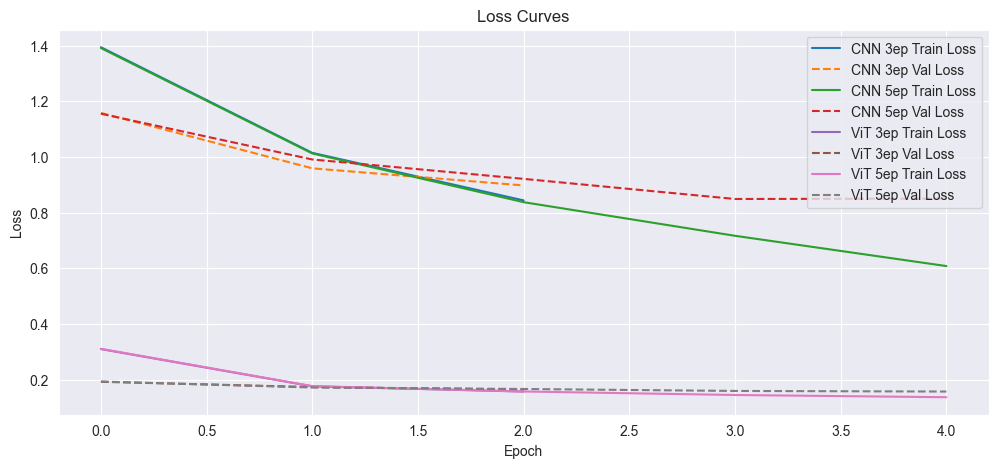

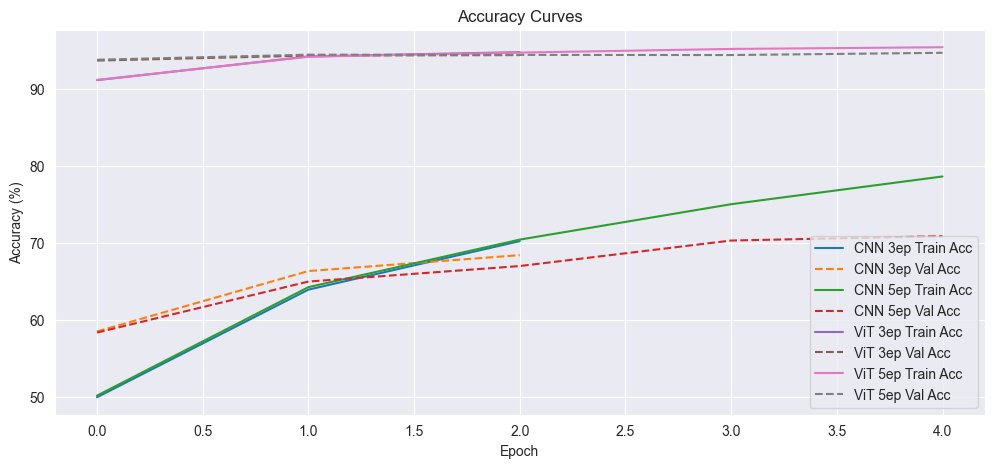

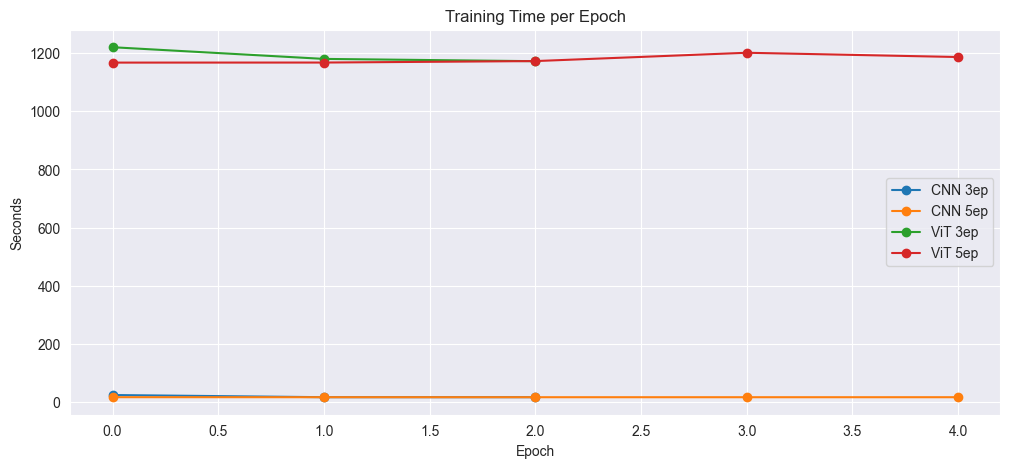

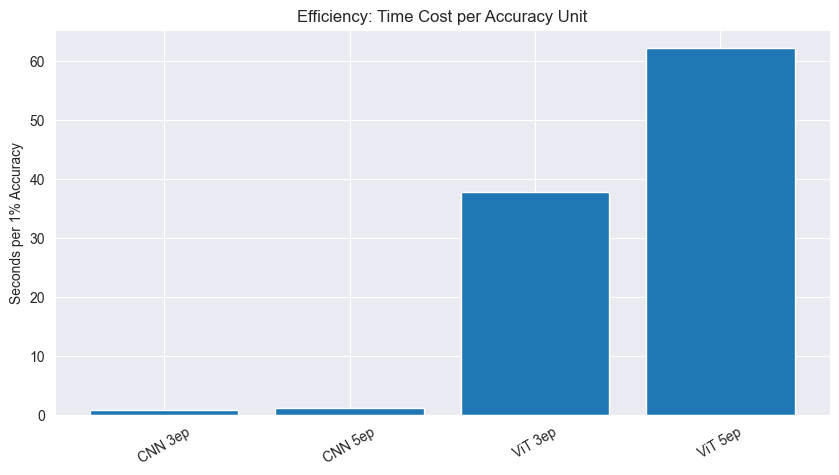


⏱ Efficiency Table:
CNN 3ep         : 0.84 seconds per 1% accuracy
CNN 5ep         : 1.17 seconds per 1% accuracy
ViT 3ep         : 37.83 seconds per 1% accuracy
ViT 5ep         : 62.23 seconds per 1% accuracy


In [18]:

plot_history(results)
plot_times_and_efficiency(results)


=== Confusion Matrix for CNN 3ep ===


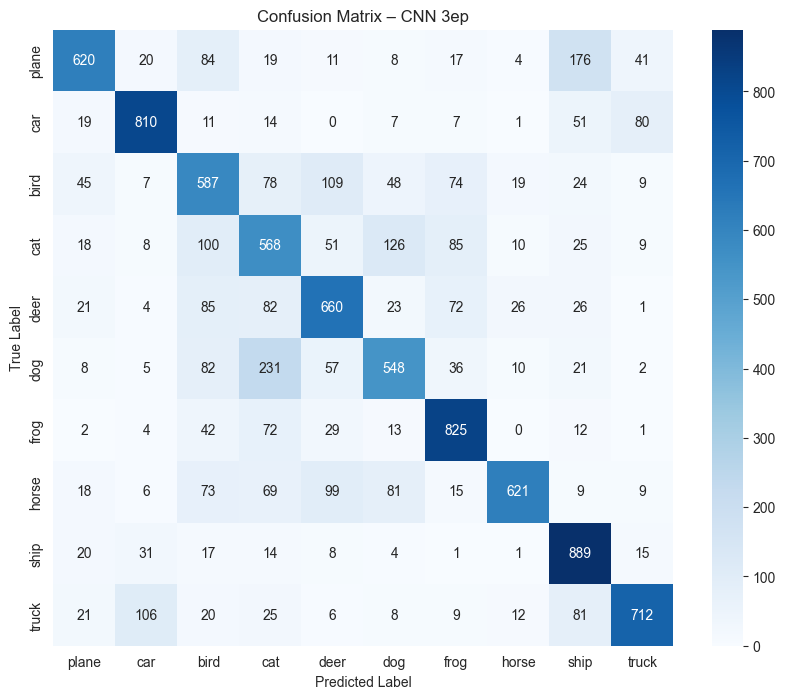


=== Confusion Matrix for CNN 5ep ===


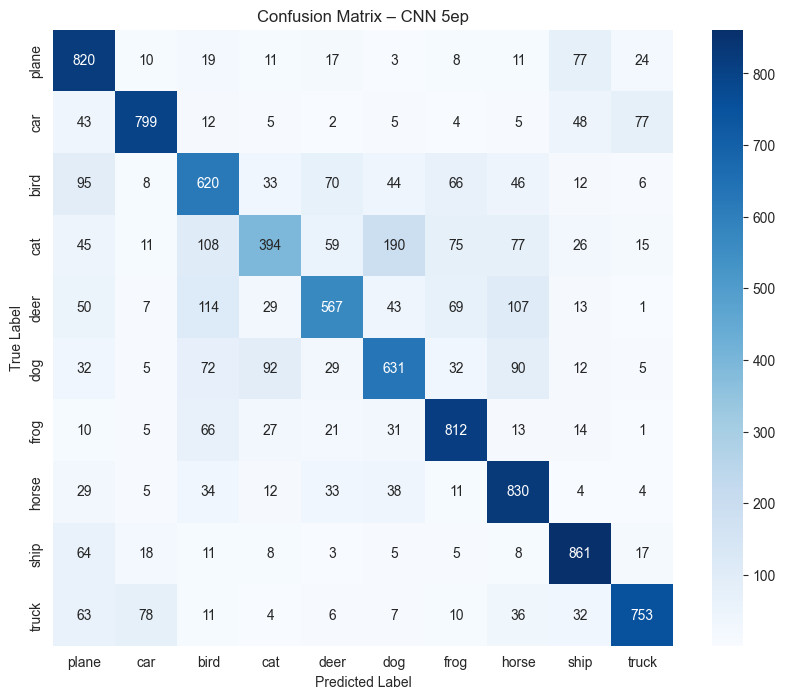


=== Confusion Matrix for ViT 3ep ===


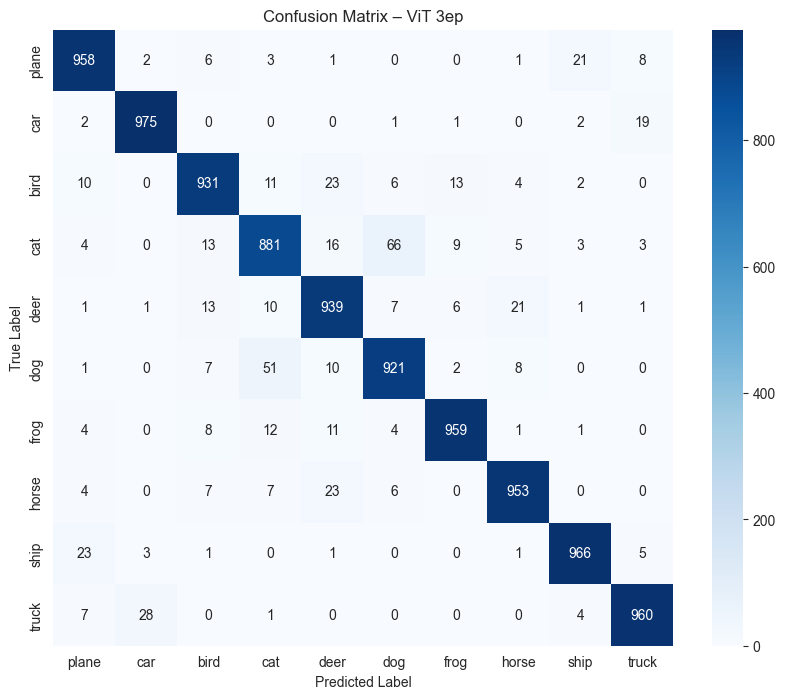


=== Confusion Matrix for ViT 5ep ===


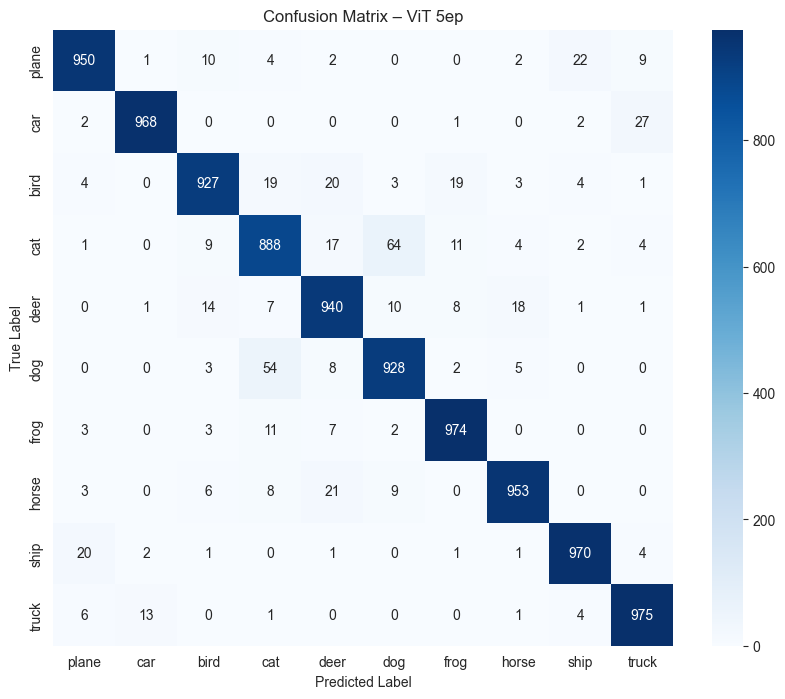

In [19]:
# Λίστα με τα μοντέλα και τους αντίστοιχους loaders
models_and_loaders = {
    "CNN 3ep": (cnn_model_3ep, testloader_cnn),
    "CNN 5ep": (cnn_model_5ep, testloader_cnn),
    "ViT 3ep": (vit_model_3ep, testloader_vit),
    "ViT 5ep": (vit_model_5ep, testloader_vit)
}

# Υπολογισμός και plot των confusion matrices
for name, (model, loader) in models_and_loaders.items():
    print(f"\n=== Confusion Matrix for {name} ===")
    cm = compute_confusion_matrix(model, loader, device)
    plot_confusion_matrix(cm, classes, f"Confusion Matrix – {name}")




=== Sample Predictions for CNN 3ep ===


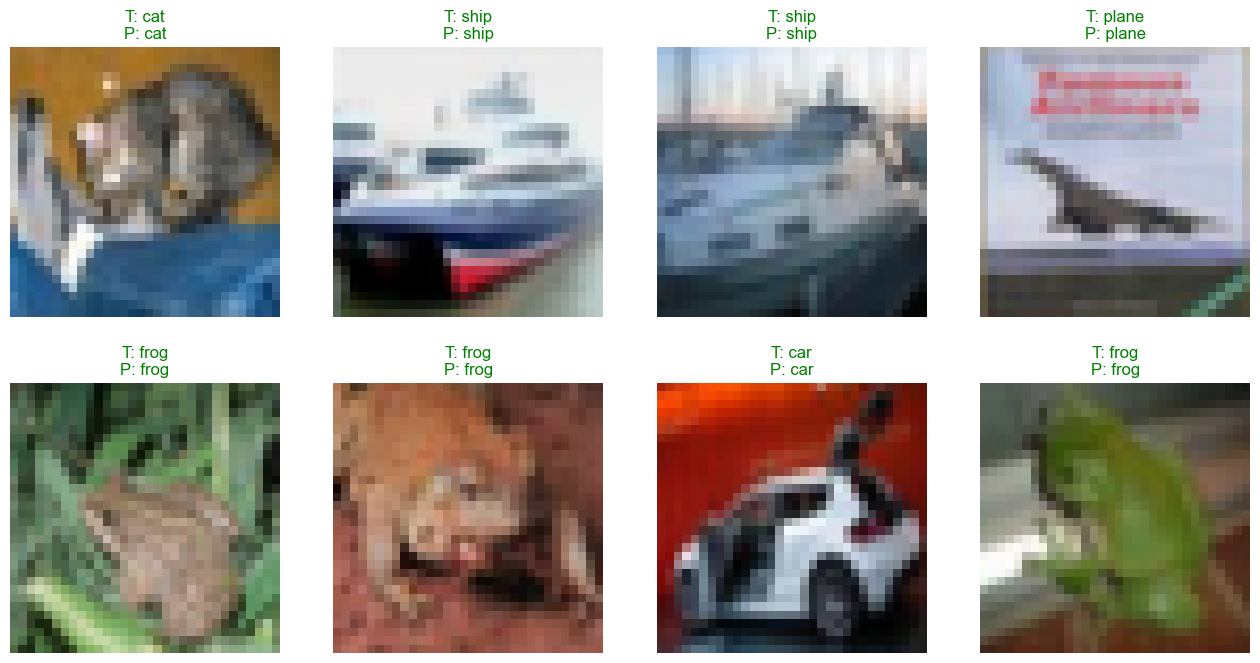


=== Sample Predictions for CNN 5ep ===


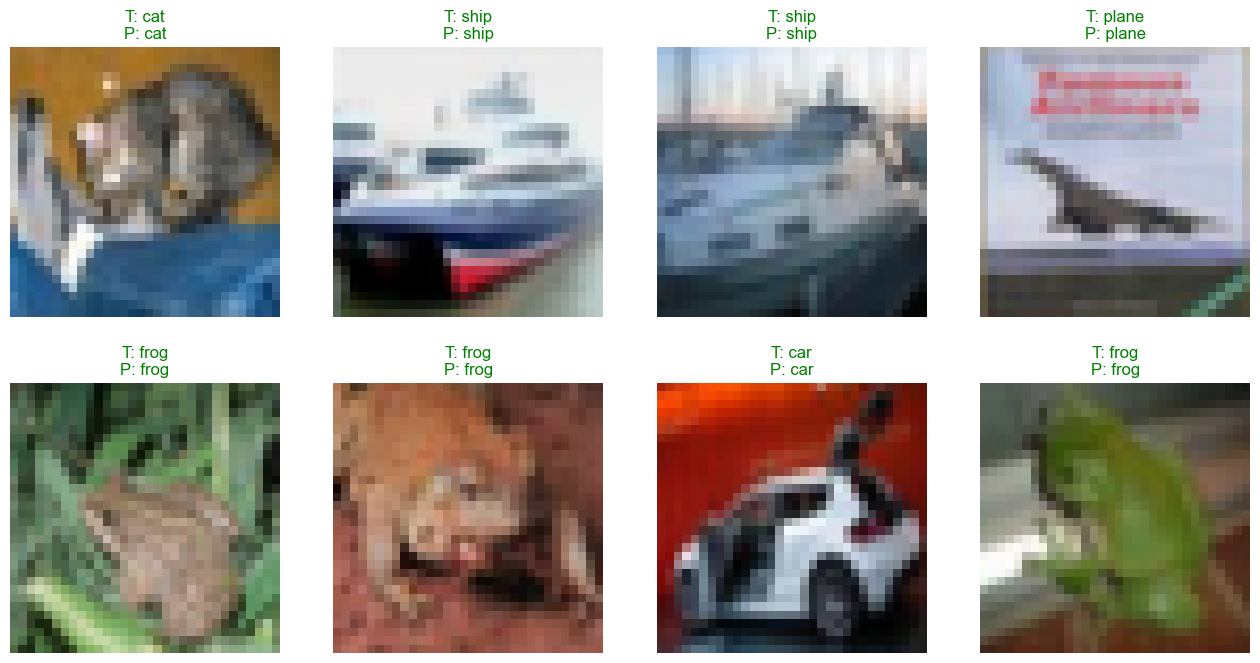


=== Sample Predictions for ViT 3ep ===


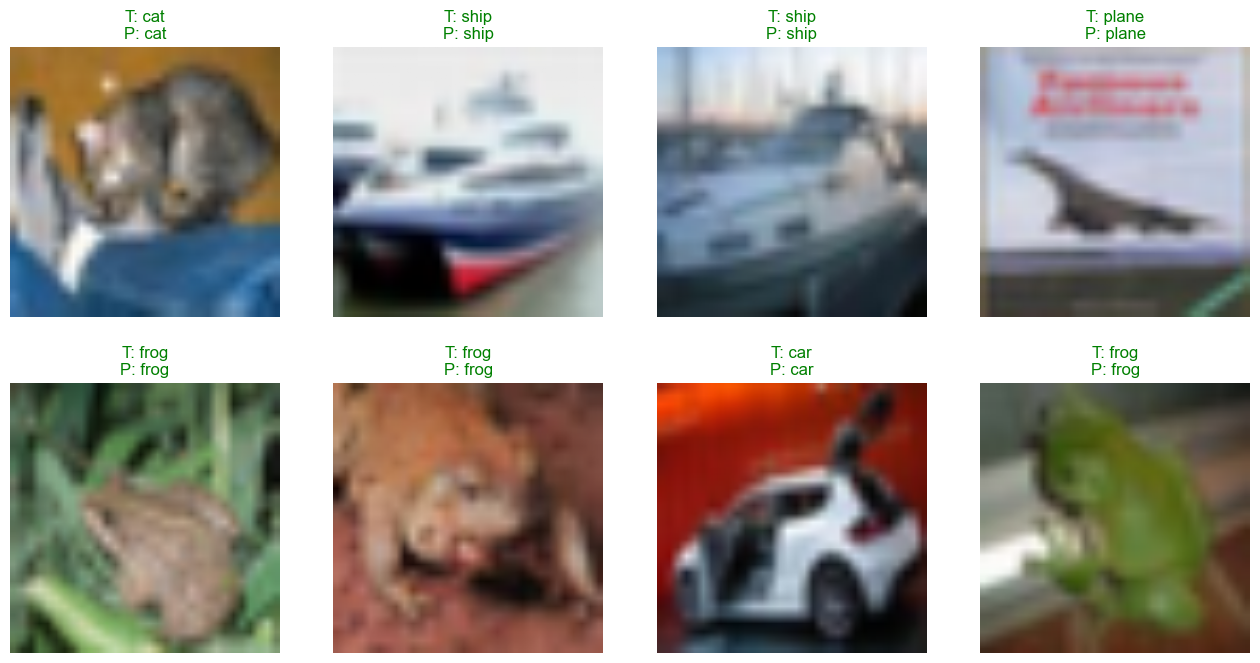


=== Sample Predictions for ViT 5ep ===


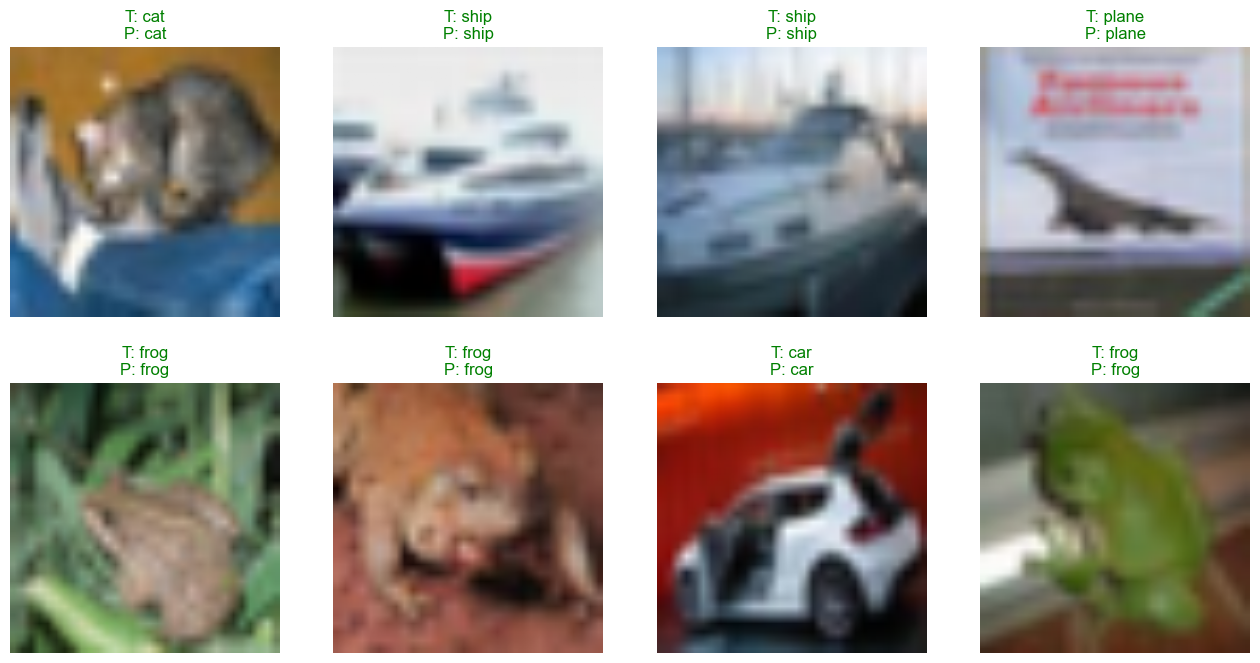

In [20]:
for name, (model, loader) in models_and_loaders.items():
    print(f"\n=== Sample Predictions for {name} ===")
    show_predictions(model, loader, classes, device, num_images=8)


[CNN (time-budget)] Epoch 1 | Time: 18.0s | Train Acc: 50.11% | Val Acc: 56.20%


[CNN (time-budget)] Epoch 2 | Time: 36.7s | Train Acc: 63.97% | Val Acc: 65.78%


[CNN (time-budget)] Epoch 3 | Time: 55.5s | Train Acc: 69.75% | Val Acc: 68.84%


[CNN (time-budget)] Epoch 4 | Time: 74.2s | Train Acc: 74.00% | Val Acc: 71.10%


[CNN (time-budget)] Epoch 5 | Time: 92.9s | Train Acc: 77.83% | Val Acc: 72.30%


[CNN (time-budget)] Epoch 6 | Time: 111.6s | Train Acc: 81.31% | Val Acc: 71.86%


[CNN (time-budget)] Epoch 7 | Time: 130.4s | Train Acc: 84.45% | Val Acc: 71.87%


[CNN (time-budget)] Epoch 8 | Time: 149.1s | Train Acc: 87.68% | Val Acc: 72.58%


[CNN (time-budget)] Epoch 9 | Time: 168.0s | Train Acc: 90.68% | Val Acc: 72.46%


[CNN (time-budget)] Epoch 10 | Time: 186.9s | Train Acc: 93.36% | Val Acc: 73.01%


[CNN (time-budget)] Epoch 11 | Time: 205.8s | Train Acc: 95.34% | Val Acc: 72.59%


[CNN (time-budget)] Epoch 12 | Time: 224.5s | Train Acc: 96.76% | Val Acc: 72.61%


[CNN (time-budget)] Epoch 13 | Time: 243.2s | Train Acc: 97.54% | Val Acc: 72.34%


[CNN (time-budget)] Epoch 14 | Time: 262.0s | Train Acc: 98.12% | Val Acc: 71.80%


[CNN (time-budget)] Epoch 15 | Time: 280.8s | Train Acc: 98.41% | Val Acc: 71.39%


[CNN (time-budget)] Epoch 16 | Time: 299.6s | Train Acc: 98.30% | Val Acc: 70.89%


[CNN (time-budget)] Epoch 17 | Time: 318.4s | Train Acc: 98.18% | Val Acc: 71.43%


[CNN (time-budget)] Epoch 18 | Time: 337.2s | Train Acc: 98.32% | Val Acc: 70.85%


[CNN (time-budget)] Epoch 19 | Time: 356.1s | Train Acc: 98.66% | Val Acc: 71.80%


[CNN (time-budget)] Epoch 20 | Time: 374.8s | Train Acc: 98.97% | Val Acc: 71.18%


[CNN (time-budget)] Epoch 21 | Time: 393.7s | Train Acc: 98.43% | Val Acc: 71.04%


[CNN (time-budget)] Epoch 22 | Time: 412.5s | Train Acc: 98.36% | Val Acc: 71.99%


[CNN (time-budget)] Epoch 23 | Time: 431.3s | Train Acc: 99.02% | Val Acc: 72.14%


[CNN (time-budget)] Epoch 24 | Time: 450.1s | Train Acc: 98.56% | Val Acc: 71.25%


[CNN (time-budget)] Epoch 25 | Time: 469.0s | Train Acc: 98.67% | Val Acc: 71.83%


[CNN (time-budget)] Epoch 26 | Time: 487.7s | Train Acc: 99.09% | Val Acc: 71.26%


[CNN (time-budget)] Epoch 27 | Time: 506.5s | Train Acc: 98.88% | Val Acc: 71.35%


[CNN (time-budget)] Epoch 28 | Time: 525.4s | Train Acc: 98.94% | Val Acc: 71.75%


[CNN (time-budget)] Epoch 29 | Time: 544.2s | Train Acc: 99.07% | Val Acc: 71.59%


[CNN (time-budget)] Epoch 30 | Time: 563.0s | Train Acc: 98.72% | Val Acc: 71.70%


[CNN (time-budget)] Epoch 31 | Time: 581.9s | Train Acc: 99.19% | Val Acc: 71.69%


[CNN (time-budget)] Epoch 32 | Time: 600.7s | Train Acc: 99.26% | Val Acc: 71.62%


[CNN (time-budget)] Epoch 33 | Time: 619.5s | Train Acc: 98.87% | Val Acc: 70.73%


[CNN (time-budget)] Epoch 34 | Time: 638.3s | Train Acc: 98.94% | Val Acc: 71.47%


[CNN (time-budget)] Epoch 35 | Time: 657.1s | Train Acc: 99.10% | Val Acc: 71.12%


[CNN (time-budget)] Epoch 36 | Time: 675.9s | Train Acc: 99.26% | Val Acc: 72.12%


[CNN (time-budget)] Epoch 37 | Time: 694.8s | Train Acc: 99.28% | Val Acc: 71.32%


[CNN (time-budget)] Epoch 38 | Time: 713.6s | Train Acc: 99.13% | Val Acc: 70.53%


[CNN (time-budget)] Epoch 39 | Time: 732.6s | Train Acc: 98.78% | Val Acc: 71.11%


[CNN (time-budget)] Epoch 40 | Time: 751.3s | Train Acc: 99.09% | Val Acc: 71.08%


[CNN (time-budget)] Epoch 41 | Time: 770.0s | Train Acc: 99.24% | Val Acc: 71.10%


[CNN (time-budget)] Epoch 42 | Time: 788.9s | Train Acc: 99.13% | Val Acc: 70.84%


[CNN (time-budget)] Epoch 43 | Time: 807.7s | Train Acc: 99.38% | Val Acc: 71.09%


[CNN (time-budget)] Epoch 44 | Time: 826.7s | Train Acc: 99.14% | Val Acc: 71.39%


[CNN (time-budget)] Epoch 45 | Time: 845.6s | Train Acc: 99.12% | Val Acc: 71.38%


[CNN (time-budget)] Epoch 46 | Time: 864.4s | Train Acc: 99.37% | Val Acc: 70.77%


[CNN (time-budget)] Epoch 47 | Time: 883.3s | Train Acc: 99.12% | Val Acc: 71.50%


[CNN (time-budget)] Epoch 48 | Time: 902.1s | Train Acc: 99.31% | Val Acc: 71.38%


[CNN (time-budget)] Epoch 49 | Time: 920.9s | Train Acc: 99.39% | Val Acc: 70.99%


[CNN (time-budget)] Epoch 50 | Time: 939.7s | Train Acc: 99.26% | Val Acc: 71.32%


[CNN (time-budget)] Epoch 51 | Time: 958.5s | Train Acc: 99.16% | Val Acc: 70.98%


[CNN (time-budget)] Epoch 52 | Time: 977.3s | Train Acc: 99.23% | Val Acc: 71.03%


[CNN (time-budget)] Epoch 53 | Time: 996.2s | Train Acc: 99.48% | Val Acc: 71.18%


[CNN (time-budget)] Epoch 54 | Time: 1015.1s | Train Acc: 99.28% | Val Acc: 71.10%


[CNN (time-budget)] Epoch 55 | Time: 1033.9s | Train Acc: 99.16% | Val Acc: 71.47%


[CNN (time-budget)] Epoch 56 | Time: 1052.9s | Train Acc: 99.22% | Val Acc: 70.72%


[CNN (time-budget)] Epoch 57 | Time: 1071.7s | Train Acc: 99.59% | Val Acc: 71.39%


[CNN (time-budget)] Epoch 58 | Time: 1090.5s | Train Acc: 99.36% | Val Acc: 70.31%


[CNN (time-budget)] Epoch 59 | Time: 1109.3s | Train Acc: 99.34% | Val Acc: 71.09%


[CNN (time-budget)] Epoch 60 | Time: 1128.0s | Train Acc: 99.37% | Val Acc: 71.13%


[CNN (time-budget)] Epoch 61 | Time: 1146.8s | Train Acc: 99.38% | Val Acc: 71.52%


[CNN (time-budget)] Epoch 62 | Time: 1165.7s | Train Acc: 99.47% | Val Acc: 70.88%


[CNN (time-budget)] Epoch 63 | Time: 1184.5s | Train Acc: 99.36% | Val Acc: 71.11%


[CNN (time-budget)] Epoch 64 | Time: 1203.4s | Train Acc: 99.34% | Val Acc: 71.09%


[CNN (time-budget)] Epoch 65 | Time: 1222.2s | Train Acc: 99.37% | Val Acc: 70.89%


[CNN (time-budget)] Epoch 66 | Time: 1241.2s | Train Acc: 99.49% | Val Acc: 71.28%


[CNN (time-budget)] Epoch 67 | Time: 1260.0s | Train Acc: 99.34% | Val Acc: 71.60%


[CNN (time-budget)] Epoch 68 | Time: 1278.8s | Train Acc: 99.33% | Val Acc: 70.99%


[CNN (time-budget)] Epoch 69 | Time: 1297.7s | Train Acc: 99.21% | Val Acc: 71.77%


[CNN (time-budget)] Epoch 70 | Time: 1316.5s | Train Acc: 99.60% | Val Acc: 70.50%


[CNN (time-budget)] Epoch 71 | Time: 1335.4s | Train Acc: 99.41% | Val Acc: 71.36%


[CNN (time-budget)] Epoch 72 | Time: 1354.2s | Train Acc: 99.64% | Val Acc: 71.24%


[CNN (time-budget)] Epoch 73 | Time: 1373.1s | Train Acc: 99.37% | Val Acc: 71.14%


[CNN (time-budget)] Epoch 74 | Time: 1391.9s | Train Acc: 99.38% | Val Acc: 70.47%


[CNN (time-budget)] Epoch 75 | Time: 1410.8s | Train Acc: 99.34% | Val Acc: 71.34%


[CNN (time-budget)] Epoch 76 | Time: 1429.7s | Train Acc: 99.59% | Val Acc: 71.57%


[CNN (time-budget)] Epoch 77 | Time: 1448.4s | Train Acc: 99.63% | Val Acc: 70.72%


[CNN (time-budget)] Epoch 78 | Time: 1467.3s | Train Acc: 99.39% | Val Acc: 70.72%


[CNN (time-budget)] Epoch 79 | Time: 1486.1s | Train Acc: 99.30% | Val Acc: 71.35%


[CNN (time-budget)] Epoch 80 | Time: 1505.0s | Train Acc: 99.53% | Val Acc: 70.48%


[CNN (time-budget)] Epoch 81 | Time: 1523.9s | Train Acc: 99.51% | Val Acc: 70.47%


[CNN (time-budget)] Epoch 82 | Time: 1542.5s | Train Acc: 99.34% | Val Acc: 70.40%


[CNN (time-budget)] Epoch 83 | Time: 1561.3s | Train Acc: 99.67% | Val Acc: 70.85%


[CNN (time-budget)] Epoch 84 | Time: 1580.0s | Train Acc: 99.55% | Val Acc: 71.05%


[CNN (time-budget)] Epoch 85 | Time: 1598.8s | Train Acc: 99.41% | Val Acc: 71.24%


[CNN (time-budget)] Epoch 86 | Time: 1617.7s | Train Acc: 99.27% | Val Acc: 70.69%


[CNN (time-budget)] Epoch 87 | Time: 1636.6s | Train Acc: 99.65% | Val Acc: 71.61%


[CNN (time-budget)] Epoch 88 | Time: 1655.5s | Train Acc: 99.53% | Val Acc: 70.64%


[CNN (time-budget)] Epoch 89 | Time: 1674.3s | Train Acc: 99.62% | Val Acc: 70.98%


[CNN (time-budget)] Epoch 90 | Time: 1693.1s | Train Acc: 99.48% | Val Acc: 70.82%


[CNN (time-budget)] Epoch 91 | Time: 1712.0s | Train Acc: 99.50% | Val Acc: 70.80%


[CNN (time-budget)] Epoch 92 | Time: 1730.9s | Train Acc: 99.38% | Val Acc: 70.65%


[CNN (time-budget)] Epoch 93 | Time: 1749.7s | Train Acc: 99.52% | Val Acc: 70.12%


[CNN (time-budget)] Epoch 94 | Time: 1768.6s | Train Acc: 99.55% | Val Acc: 70.93%


[CNN (time-budget)] Epoch 95 | Time: 1787.4s | Train Acc: 99.44% | Val Acc: 70.98%


[CNN (time-budget)] Epoch 96 | Time: 1806.3s | Train Acc: 99.53% | Val Acc: 71.00%


[CNN (time-budget)] Epoch 97 | Time: 1825.2s | Train Acc: 99.78% | Val Acc: 71.67%


[CNN (time-budget)] Epoch 98 | Time: 1844.0s | Train Acc: 99.63% | Val Acc: 70.70%


[CNN (time-budget)] Epoch 99 | Time: 1862.9s | Train Acc: 99.32% | Val Acc: 70.40%


[CNN (time-budget)] Epoch 100 | Time: 1881.7s | Train Acc: 99.44% | Val Acc: 71.34%


[CNN (time-budget)] Epoch 101 | Time: 1900.5s | Train Acc: 99.55% | Val Acc: 71.18%


[CNN (time-budget)] Epoch 102 | Time: 1919.4s | Train Acc: 99.48% | Val Acc: 70.74%


[CNN (time-budget)] Epoch 103 | Time: 1938.2s | Train Acc: 99.57% | Val Acc: 70.90%


[CNN (time-budget)] Epoch 104 | Time: 1957.1s | Train Acc: 99.67% | Val Acc: 71.08%


[CNN (time-budget)] Epoch 105 | Time: 1976.0s | Train Acc: 99.55% | Val Acc: 70.81%


[CNN (time-budget)] Epoch 106 | Time: 1994.9s | Train Acc: 99.59% | Val Acc: 71.31%


[CNN (time-budget)] Epoch 107 | Time: 2013.8s | Train Acc: 99.71% | Val Acc: 71.55%


[CNN (time-budget)] Epoch 108 | Time: 2032.7s | Train Acc: 99.54% | Val Acc: 70.94%


[CNN (time-budget)] Epoch 109 | Time: 2051.6s | Train Acc: 99.55% | Val Acc: 71.45%


[CNN (time-budget)] Epoch 110 | Time: 2070.4s | Train Acc: 99.45% | Val Acc: 71.33%


[CNN (time-budget)] Epoch 111 | Time: 2089.3s | Train Acc: 99.72% | Val Acc: 70.73%


[CNN (time-budget)] Epoch 112 | Time: 2108.1s | Train Acc: 99.58% | Val Acc: 71.33%


[CNN (time-budget)] Epoch 113 | Time: 2126.9s | Train Acc: 99.55% | Val Acc: 71.23%


[CNN (time-budget)] Epoch 114 | Time: 2145.8s | Train Acc: 99.45% | Val Acc: 71.07%


[CNN (time-budget)] Epoch 115 | Time: 2164.6s | Train Acc: 99.71% | Val Acc: 71.50%


[CNN (time-budget)] Epoch 116 | Time: 2183.6s | Train Acc: 99.60% | Val Acc: 71.41%


[CNN (time-budget)] Epoch 117 | Time: 2202.4s | Train Acc: 99.76% | Val Acc: 71.90%


[CNN (time-budget)] Epoch 118 | Time: 2221.3s | Train Acc: 99.63% | Val Acc: 70.45%


[CNN (time-budget)] Epoch 119 | Time: 2240.2s | Train Acc: 99.55% | Val Acc: 71.19%


[CNN (time-budget)] Epoch 120 | Time: 2259.1s | Train Acc: 99.56% | Val Acc: 70.90%


[CNN (time-budget)] Epoch 121 | Time: 2278.0s | Train Acc: 99.53% | Val Acc: 71.39%


[CNN (time-budget)] Epoch 122 | Time: 2296.9s | Train Acc: 99.69% | Val Acc: 70.72%


[CNN (time-budget)] Epoch 123 | Time: 2316.0s | Train Acc: 99.55% | Val Acc: 71.38%


[CNN (time-budget)] Epoch 124 | Time: 2334.8s | Train Acc: 99.52% | Val Acc: 70.44%


[CNN (time-budget)] Epoch 125 | Time: 2353.8s | Train Acc: 99.57% | Val Acc: 70.69%


[CNN (time-budget)] Epoch 126 | Time: 2372.7s | Train Acc: 99.71% | Val Acc: 71.14%


[CNN (time-budget)] Epoch 127 | Time: 2391.5s | Train Acc: 99.60% | Val Acc: 71.18%


[CNN (time-budget)] Epoch 128 | Time: 2410.5s | Train Acc: 99.60% | Val Acc: 70.80%


[CNN (time-budget)] Epoch 129 | Time: 2429.6s | Train Acc: 99.49% | Val Acc: 71.06%


[CNN (time-budget)] Epoch 130 | Time: 2448.5s | Train Acc: 99.54% | Val Acc: 70.66%


[CNN (time-budget)] Epoch 131 | Time: 2467.4s | Train Acc: 99.66% | Val Acc: 70.59%


[CNN (time-budget)] Epoch 132 | Time: 2486.3s | Train Acc: 99.67% | Val Acc: 70.32%


[CNN (time-budget)] Epoch 133 | Time: 2505.1s | Train Acc: 99.65% | Val Acc: 71.40%


[CNN (time-budget)] Epoch 134 | Time: 2524.0s | Train Acc: 99.68% | Val Acc: 71.12%


[CNN (time-budget)] Epoch 135 | Time: 2543.1s | Train Acc: 99.82% | Val Acc: 71.12%


[CNN (time-budget)] Epoch 136 | Time: 2562.0s | Train Acc: 99.66% | Val Acc: 70.88%


[CNN (time-budget)] Epoch 137 | Time: 2580.9s | Train Acc: 99.58% | Val Acc: 70.49%


[CNN (time-budget)] Epoch 138 | Time: 2599.7s | Train Acc: 99.53% | Val Acc: 70.55%


[CNN (time-budget)] Epoch 139 | Time: 2618.7s | Train Acc: 99.50% | Val Acc: 70.37%


[CNN (time-budget)] Epoch 140 | Time: 2637.8s | Train Acc: 99.66% | Val Acc: 71.11%


[CNN (time-budget)] Epoch 141 | Time: 2656.7s | Train Acc: 99.70% | Val Acc: 70.72%


[CNN (time-budget)] Epoch 142 | Time: 2675.6s | Train Acc: 99.63% | Val Acc: 70.85%


[CNN (time-budget)] Epoch 143 | Time: 2694.4s | Train Acc: 99.48% | Val Acc: 71.15%


[CNN (time-budget)] Epoch 144 | Time: 2713.1s | Train Acc: 99.70% | Val Acc: 70.60%


[CNN (time-budget)] Epoch 145 | Time: 2732.2s | Train Acc: 99.60% | Val Acc: 70.10%


[CNN (time-budget)] Epoch 146 | Time: 2751.0s | Train Acc: 99.68% | Val Acc: 71.12%


[CNN (time-budget)] Epoch 147 | Time: 2769.9s | Train Acc: 99.68% | Val Acc: 70.44%


[CNN (time-budget)] Epoch 148 | Time: 2788.8s | Train Acc: 99.75% | Val Acc: 71.60%


[CNN (time-budget)] Epoch 149 | Time: 2807.7s | Train Acc: 99.63% | Val Acc: 70.99%


[CNN (time-budget)] Epoch 150 | Time: 2826.7s | Train Acc: 99.61% | Val Acc: 70.93%


[CNN (time-budget)] Epoch 151 | Time: 2845.6s | Train Acc: 99.57% | Val Acc: 71.16%


[CNN (time-budget)] Epoch 152 | Time: 2864.5s | Train Acc: 99.62% | Val Acc: 70.88%


[CNN (time-budget)] Epoch 153 | Time: 2883.4s | Train Acc: 99.64% | Val Acc: 70.69%


[CNN (time-budget)] Epoch 154 | Time: 2902.4s | Train Acc: 99.74% | Val Acc: 71.47%


[CNN (time-budget)] Epoch 155 | Time: 2921.4s | Train Acc: 99.64% | Val Acc: 71.13%


[CNN (time-budget)] Epoch 156 | Time: 2940.3s | Train Acc: 99.63% | Val Acc: 70.90%


[CNN (time-budget)] Epoch 157 | Time: 2958.1s | Train Acc: 99.77% | Val Acc: 71.10%


[CNN (time-budget)] Epoch 158 | Time: 2977.0s | Train Acc: 99.61% | Val Acc: 70.82%


[CNN (time-budget)] Epoch 159 | Time: 2995.9s | Train Acc: 99.55% | Val Acc: 70.22%


[CNN (time-budget)] Epoch 160 | Time: 3014.8s | Train Acc: 99.61% | Val Acc: 70.91%


[CNN (time-budget)] Epoch 161 | Time: 3033.6s | Train Acc: 99.67% | Val Acc: 71.02%


[CNN (time-budget)] Epoch 162 | Time: 3052.4s | Train Acc: 99.70% | Val Acc: 70.79%


[CNN (time-budget)] Epoch 163 | Time: 3071.3s | Train Acc: 99.55% | Val Acc: 71.20%


[CNN (time-budget)] Epoch 164 | Time: 3090.3s | Train Acc: 99.70% | Val Acc: 71.43%


[CNN (time-budget)] Epoch 165 | Time: 3109.1s | Train Acc: 99.76% | Val Acc: 71.04%


[CNN (time-budget)] Epoch 166 | Time: 3127.9s | Train Acc: 99.76% | Val Acc: 70.76%


[CNN (time-budget)] Epoch 167 | Time: 3146.8s | Train Acc: 99.61% | Val Acc: 71.36%


[CNN (time-budget)] Epoch 168 | Time: 3165.8s | Train Acc: 99.65% | Val Acc: 70.60%


[CNN (time-budget)] Epoch 169 | Time: 3184.6s | Train Acc: 99.69% | Val Acc: 71.27%
⏱ Time budget reached for CNN (time-budget)


KeyError: 'time'

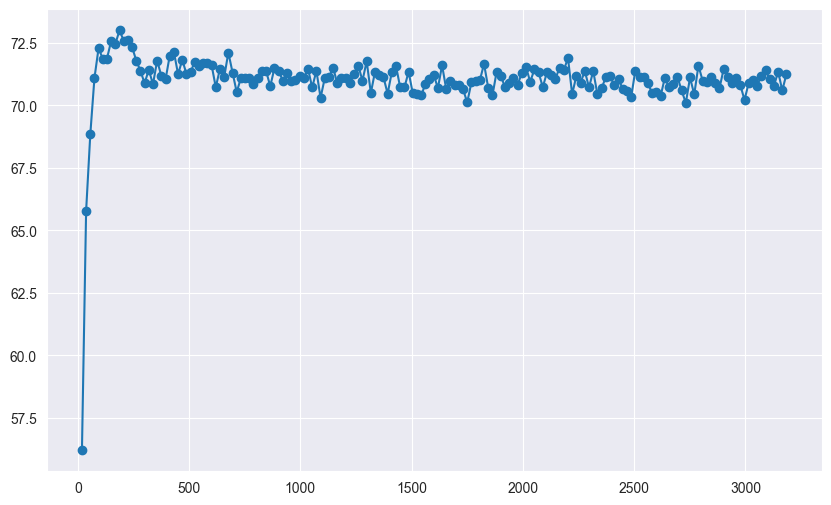

In [21]:
TIME_BUDGET = 3180  # seconds (~53 minutes)

cnn_model = SimpleCNN()
cnn_time_history = train_with_time_budget(
    model=cnn_model,
    train_loader=trainloader_cnn,
    test_loader=testloader_cnn,
    max_seconds=TIME_BUDGET,
    lr=1e-3,
    device=device,
    name="CNN (time-budget)"
)



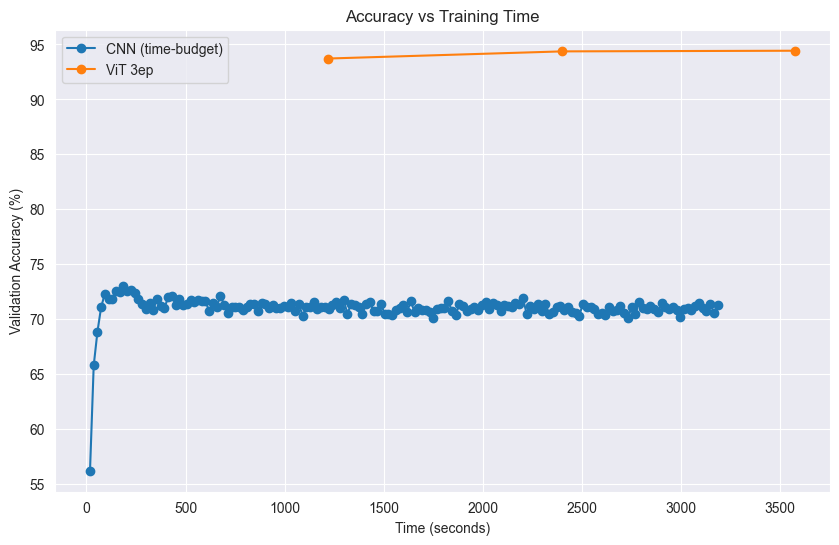

In [25]:
history_vit_time = {
    "time": np.cumsum(history_vit["epoch_time"]).tolist(),
    "val_acc": history_vit["val_acc"]
}


plot_accuracy_vs_time({
    "CNN (time-budget)": cnn_time_history,
    "ViT 3ep": history_vit_time
})